원본 클러스터 레이블: [4 4 4 4 4 7 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6
 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1
 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7
 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 5 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7 7 7 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 6
 6 6 6 6 6 6 6 6 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7 7 7 0 0 0 0
 1 1 1 1 1 1 1 1 1 1 1 1 6 6 8 8 8 8 8 8 8 8 8 8 8 5 5 5 5 5 4 4 4 4 4 4 4
 4 4 4 4 4 4 7 7 7 7 7 0 0 0 0 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6
 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7 7 0 0 0 7 7 1 1 1 1 1
 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 7
 7 7 7 7 7 0 0 0 1 1 1 1 1 1 1 1 1 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 5 5 5 5
 5 5 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7 7 7 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 6 6 6 6 6 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 7 7 7 7 7 7 0 0
 0 0 1 1 1 1

In [122]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.model_selection import  GridSearchCV
import matplotlib.pyplot as plt


In [72]:
dir(sklearn.model_selection)

['BaseCrossValidator',
 'BaseShuffleSplit',
 'FixedThresholdClassifier',
 'GridSearchCV',
 'GroupKFold',
 'GroupShuffleSplit',
 'KFold',
 'LearningCurveDisplay',
 'LeaveOneGroupOut',
 'LeaveOneOut',
 'LeavePGroupsOut',
 'LeavePOut',
 'ParameterGrid',
 'ParameterSampler',
 'PredefinedSplit',
 'RandomizedSearchCV',
 'RepeatedKFold',
 'RepeatedStratifiedKFold',
 'ShuffleSplit',
 'StratifiedGroupKFold',
 'StratifiedKFold',
 'StratifiedShuffleSplit',
 'TimeSeriesSplit',
 'TunedThresholdClassifierCV',
 'ValidationCurveDisplay',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__getattr__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_classification_threshold',
 '_plot',
 '_search',
 '_split',
 '_validation',
 'check_cv',
 'cross_val_predict',
 'cross_val_score',
 'cross_validate',
 'learning_curve',
 'permutation_test_score',
 'train_test_split',
 'typing',
 'validation_curve']

In [46]:
# 분류 
ocean_data = pd.read_csv('data/rate_ocean_final.csv')

ocean_data.set_index('Date',inplace=True)
ocean_data['Target']= new_labels_alternative

In [7]:
def create_sequence(data, window_size,target_name):
    y_data= data[[target_name]].values
    times = data.index
    data = data.values
    X, y = [], []
    time_list = []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(y_data[i + window_size])
        time_list.append(times[i + window_size])
    X, y = np.array(X), np.array(y)
    return X,y,time_list

In [47]:
X,y,time_list = create_sequence(ocean_data, 4,'Target')

In [52]:
split_index = int(len(X) * 0.8)
X_train_raw, y_train_raw = X[:split_index], y[:split_index]
X_test_raw, y_test_raw = X[split_index:], y[split_index:]
time_list_train,time_list_test=time_list[:split_index],time_list[split_index:]
feauture_num = X_train_raw.shape[2]

In [53]:
scaler= MinMaxScaler()

In [152]:
X_train_scaled = scaler.fit_transform(X_train_raw.reshape(-1, feauture_num)).reshape(X_train_raw.shape)
y_train =to_categorical(y_train_raw)


X_test_scaled = scaler.transform(X_test_raw.reshape(-1, feauture_num)).reshape(X_test_raw.shape)
y_test = to_categorical(y_test_raw)

X_train=X_train_scaled
X_train
X_test=X_test_scaled
X_test

array([[[0.69583333, 0.03252886, 0.09756098, ..., 0.31232877,
         0.38600451, 0.875     ],
        [0.57395833, 0.10912907, 0.17073171, ..., 0.29863014,
         0.29571106, 0.875     ],
        [0.73020833, 0.0409234 , 0.13883677, ..., 0.29863014,
         0.29571106, 0.875     ],
        [0.73854167, 0.00314795, 0.11444653, ..., 0.29863014,
         0.29571106, 0.875     ]],

       [[0.57395833, 0.10912907, 0.17073171, ..., 0.29863014,
         0.29571106, 0.875     ],
        [0.73020833, 0.0409234 , 0.13883677, ..., 0.29863014,
         0.29571106, 0.875     ],
        [0.73854167, 0.00314795, 0.11444653, ..., 0.29863014,
         0.29571106, 0.875     ],
        [0.81458333, 0.00209864, 0.10506567, ..., 0.29863014,
         0.29571106, 0.875     ]],

       [[0.73020833, 0.0409234 , 0.13883677, ..., 0.29863014,
         0.29571106, 0.875     ],
        [0.73854167, 0.00314795, 0.11444653, ..., 0.29863014,
         0.29571106, 0.875     ],
        [0.81458333, 0.00209864, 0.1

In [141]:
y_test.shape

(145, 8)

In [ ]:
xgb = XGBClassifier(random_state=42,)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.3586206896551724
혼동행렬:
 [[11  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 25  2  0  0]
 [ 0 30  0  0  0  2 25  0]
 [ 0  0  0  0  5  0  0  0]
 [ 2  0  0  0  0 18  2  0]
 [ 0  0  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0 10]]
분류보고서
               precision    recall  f1-score   support

           0       0.61      1.00      0.76        11
           1       0.21      1.00      0.35         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.17      1.00      0.29         5
           5       0.82      0.82      0.82        22
           6       0.00      0.00      0.00         0
           7       1.00      0.67      0.80        15

    accuracy                           0.36       145
   macro avg       0.35      0.56      0.38       145
weighted avg       0.29      0.36      0.29       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.2689655172413793
혼동행렬:
 [[ 6  4  0  0  0  0  0  1]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 25  2  0  0]
 [ 0 47  0  0  0  0 10  0]
 [ 0  0  0  0  4  0  0  1]
 [ 0  2  0  0  1 15  4  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1  4  0  0  1  1  2  6]]
분류보고서
               precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.12      1.00      0.22         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.13      0.80      0.22         5
           5       0.83      0.68      0.75        22
           6       0.00      0.00      0.00         0
           7       0.75      0.40      0.52        15

    accuracy                           0.27       145
   macro avg       0.34      0.43      0.30       145
weighted avg       0.28      0.27      0.24       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [68]:
# RF
RF = RandomForestClassifier(random_state=42)
RF.fit(X_train,y_train)
y_pred=RF.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.33793103448275863
혼동행렬:
 [[ 9  2  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 26  1  0  0]
 [ 3 18  0  0  0  0 36  0]
 [ 0  0  0  0  5  0  0  0]
 [ 2  0  0  0  0 16  4  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  1  0  0 11]]
분류보고서
               precision    recall  f1-score   support

           0       0.53      0.82      0.64        11
           1       0.29      1.00      0.44         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.16      1.00      0.27         5
           5       0.94      0.73      0.82        22
           6       0.00      0.00      0.00         0
           7       1.00      0.73      0.85        15

    accuracy                           0.34       145
   macro avg       0.36      0.53      0.38       145
weighted avg       0.31      0.34      0.29       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
model_xgb = XGBClassifier(random_state=42)
hyperparams_xgb = {'n_estimators': [100, 200, 300],
				 'learning_rate': [0.01, 0.05, 0.1],
				 'max_depth': [3, 5, 7]}    
model_rf = RandomForestClassifier(random_state=42)
hyperparams_rf = {'n_estimators': [10, 50, 100],
				'max_depth': [None, 10, 20],
				'min_samples_split': [2, 5, 10],
				'min_samples_leaf': [1, 2, 4],
				'bootstrap': [True, False],}

In [ ]:
model_info = GridSearchCV(estimator=model_xgb,
                    param_grid = hyperparams_xgb,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.36551724137931035
혼동행렬:
 [[11  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 1  0  0  0 25  1  0  0]
 [ 2 28  0  0  0  1 26  0]
 [ 0  0  0  0  5  0  0  0]
 [ 3  0  0  0  0 18  1  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  1  0  0 11]]
분류보고서
               precision    recall  f1-score   support

           0       0.55      1.00      0.71        11
           1       0.22      1.00      0.36         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.16      1.00      0.28         5
           5       0.90      0.82      0.86        22
           6       0.00      0.00      0.00         0
           7       1.00      0.73      0.85        15

    accuracy                           0.37       145
   macro avg       0.35      0.57      0.38       145
weighted avg       0.30      0.37      0.30       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [115]:
rf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   time    145 non-null    object
 1   y_test  145 non-null    int64 
 2   y_pred  145 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 3.5+ KB


In [ ]:
y_test_raw = y_test_raw.reshape(-1)
y_test_raw.shape

(145,)

In [ ]:
rf_df = pd.DataFrame({'time':time_list_test,'y_test':y_test_raw,'y_pred':y_pred})


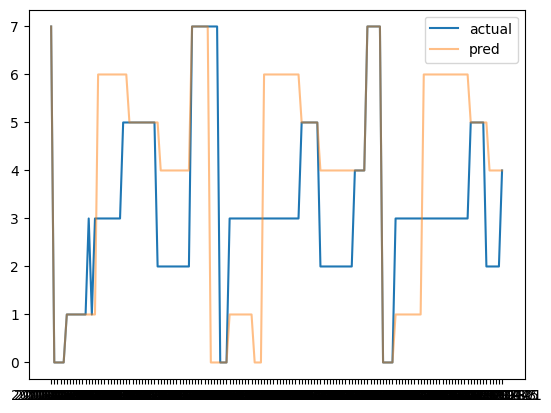

In [113]:
plt.plot(rf_df['time'],rf_df['y_test'],label='actual')
plt.plot(rf_df['time'],rf_df['y_pred'],alpha=0.5,label='pred')
plt.legend()
plt.show()

In [ ]:
model_info = GridSearchCV(estimator=model_rf,
                    param_grid = hyperparams_rf,
                    cv=5)
model_info.fit(X_train,y_train)
model_n = model_info.best_estimator_
y_pred = model_n.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

정확도: 0.38620689655172413
혼동행렬:
 [[11  0  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 25  2  0  0]
 [ 3 19  0  0  0  0 35  0]
 [ 0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0 20  2  0]
 [ 0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0 12]]
분류보고서
               precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.30      1.00      0.46         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.17      1.00      0.29         5
           5       0.91      0.91      0.91        22
           6       0.00      0.00      0.00         0
           7       1.00      0.80      0.89        15

    accuracy                           0.39       145
   macro avg       0.38      0.59      0.42       145
weighted avg       0.31      0.39      0.32       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [116]:
from tensorflow import keras

In [190]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D,Flatten,Dropout,SimpleRNN,LSTM, MaxPooling1D,AveragePooling1D,GlobalAvgPool1D

In [131]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=5,
    verbose=1,
    mode='auto' )

In [136]:
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [150]:
Fnn = Sequential()
Fnn.add(Dense(128,activation='relu',input_dim=(X_train.shape[1])))
Fnn.add(Dense(64,activation='relu'))
Fnn.add(Dense(32,activation='relu'))
Fnn.add(Dense(y_train.shape[1],activation='softmax'))
Fnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Fnn.summary()

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 128)            │        24,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,825 (136.04 KB)

 Trainable params: 34,825 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_reshape = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2])
X_test_reshape = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2])

In [155]:
Fnn_history = Fnn.fit(X_train_reshape,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2379 - loss: 1.9675 - val_accuracy: 0.3793 - val_loss: 1.4543
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5860 - loss: 1.1849 - val_accuracy: 0.6207 - val_loss: 0.9671
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7608 - loss: 0.8160 - val_accuracy: 0.7069 - val_loss: 0.6793
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8361 - loss: 0.4991 - val_accuracy: 0.7586 - val_loss: 0.5066
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8613 - loss: 0.3776 - val_accuracy: 0.8276 - val_loss: 0.3704
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8583 - loss: 0.3399 - val_accuracy: 0.7931 - val_loss: 0.5074
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9121 - loss: 0.2889 - val_accuracy: 0.7931 - val_loss: 0.4171
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9001 - loss: 0.2555 - val_accuracy: 0.8448 - 

In [157]:
y_pred = Fnn.predict(X_test_reshape)
y_pred = np.argmax(y_pred,axis=1)
print('-----------FNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
-----------FNN-----------
정확도: 0.38620689655172413
혼동행렬:
 [[10  0  0  0  0  0  0  1]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0]
 [ 1 24  0  0  0  2 30  0]
 [ 0  0  0  0  5  0  0  0]
 [ 0  0  0  0  1 20  1  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  2  0  0 13]]
분류보고서
               precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.25      1.00      0.40         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.14      1.00      0.25         5
           5       0.91      0.91      0.91        22
           6       0.00      0.00      0.00         0
           7       0.93      0.87      0.90        15

    accuracy                           0.39       145
   macro avg       0.39      0.59      0.42       145
weighted avg       0.32      0.39      0.33       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [180]:
Cnn =Sequential()
Cnn.add(Conv1D(64,3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn.add(MaxPooling1D(2))
Cnn.add(Flatten())
Cnn.add(Dense(32,activation = 'relu'))
Cnn.add(Dense(y_train.shape[1],activation='softmax'))

c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [166]:
y_train.shape

(578, 9)

In [175]:
# model=Sequential([
#             Conv1D(64,3, activation='relu', input_shape=(self.window_size,4)),
#             Conv1D(32,3,activation='relu'),
#             Flatten(),
#             Dense(50,activation='relu'),
#             Dense(1)
#         ])
#         model.compile(optimizer='adam',loss='mse')

In [ ]:
Cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Cnn.summary()
Cnn_history = Cnn.fit(X_train,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

In [ ]:
y_pred = Cnn.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print('-----------CNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

In [169]:
Rnn = Sequential()
Rnn.add(SimpleRNN(32, activation='relu', input_shape=(4,47)))
Rnn. add(Dense(9,activation='softmax'))
Rnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])


In [173]:
Rnn.summary()
Rnn_history = Rnn.fit(X_train,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,857 (11.16 KB)

 Trainable params: 2,857 (11.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.0865 - loss: 2.2594 - val_accuracy: 0.1379 - val_loss: 2.1386
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3312 - loss: 1.8214 - val_accuracy: 0.3276 - val_loss: 1.8687
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5082 - loss: 1.6093 - val_accuracy: 0.3621 - val_loss: 1.6126
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5499 - loss: 1.4325 - val_accuracy: 0.4483 - val_loss: 1.3739
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6416 - loss: 1.1760 - val_accuracy: 0.5345 - val_loss: 1.0822
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7451 - loss: 0.8440 - val_accuracy: 0.7586 - val_loss: 0.7975
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7994 - loss: 0.6452 - val_accuracy: 0.7759 - val_loss: 0.7005
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8356 - loss: 0.5228 - val_accuracy: 0.8103 -

In [174]:
y_pred = Rnn.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print('-----------RNN-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
-----------RNN-----------
정확도: 0.32413793103448274
혼동행렬:
 [[ 6  5  0  0  0  0  0  0]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 24  3  0  0]
 [ 0 20  0  0  0  0 37  0]
 [ 0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0 16  6  0]
 [ 0  0  0  0  0  0  0  0]
 [ 1  0  0  0  2  0  0 12]]
분류보고서
               precision    recall  f1-score   support

           0       0.86      0.55      0.67        11
           1       0.24      1.00      0.39         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.16      1.00      0.28         5
           5       0.84      0.73      0.78        22
           6       0.00      0.00      0.00         0
           7       1.00      0.80      0.89        15

    accuracy                           0.32       145
   macro avg       0.39      0.51      0.38       145
weighted avg       0.32      0.32      0.29       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [179]:
X_train.shape[1]

4

In [183]:
help(LSTM)

Help on class LSTM in module keras.src.layers.rnn.lstm:

class LSTM(keras.src.layers.rnn.rnn.RNN)
 |  LSTM(units, activation='tanh', recurrent_activation='sigmoid', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0, seed=None, return_sequences=False, return_state=False, go_backwards=False, stateful=False, unroll=False, use_cudnn='auto', **kwargs)
 |  
 |  Long Short-Term Memory layer - Hochreiter 1997.
 |  
 |  Based on available runtime hardware and constraints, this layer
 |  will choose different implementations (cuDNN-based or backend-native)
 |  to maximize the performance. If a GPU is available and all
 |  the arguments to the layer meet the requirement of the cuDNN kernel
 |  (see below

In [185]:
Lstm = Sequential()
Lstm.add(LSTM(units=64, activation='tanh', return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))

Lstm.add(LSTM(units=32,activation='tanh',return_sequences=True))

Lstm.add(LSTM(units=16))

#출력층
Lstm.add(Dense(9, activation='softmax'))

In [ ]:
#print(X_train.shape)

(578, 4, 47)


In [186]:
Lstm.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])
Lstm.summary()
Lstm_history = Lstm.fit(X_train,y_train,epochs=100,validation_split=0.1,callbacks=[early_stopping])

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 4, 64)          │        28,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 4, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,377 (173.35 KB)

 Trainable params: 44,377 (173.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.1632 - loss: 2.1549 - val_accuracy: 0.1379 - val_loss: 1.9893
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2717 - loss: 1.9283 - val_accuracy: 0.3276 - val_loss: 1.7888
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4882 - loss: 1.6452 - val_accuracy: 0.3276 - val_loss: 1.5767
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5345 - loss: 1.3317 - val_accuracy: 0.5172 - val_loss: 1.3181
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6543 - loss: 1.0858 - val_accuracy: 0.6379 - val_loss: 1.0715
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7553 - loss: 0.8681 - val_accuracy: 0.7414 - val_loss: 0.8615
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8152 - loss: 0.6991 - val_accuracy: 0.7069 - val_loss: 0.8705
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8594 - loss: 0.5680 - val_accuracy: 0.7069 - 

In [188]:
y_pred = Lstm.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
print('-----------LSTM-----------')
print("정확도:",accuracy_score(y_test_raw,y_pred))
print("혼동행렬:\n",confusion_matrix(y_test_raw,y_pred))
print('분류보고서\n',classification_report(y_test_raw,y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
-----------LSTM-----------
정확도: 0.2689655172413793
혼동행렬:
 [[ 2  1  0  0  0  0  0  8]
 [ 0  8  0  0  0  0  0  0]
 [ 0  0  0  0 27  0  0  0]
 [ 0 24  0  0  0  0 33  0]
 [ 0  0  0  0  5  0  0  0]
 [ 0  0  0  0  4 13  5  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  4  0  0 11]]
분류보고서
               precision    recall  f1-score   support

           0       1.00      0.18      0.31        11
           1       0.24      1.00      0.39         8
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        57
           4       0.12      1.00      0.22         5
           5       1.00      0.59      0.74        22
           6       0.00      0.00      0.00         0
           7       0.58      0.73      0.65        15

    accuracy                           0.27       145
   macro avg       0.37      0.44      0.29       145
weighted avg       0.31      0.27      0.23       145



c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\rnrgh\OneDrive\바탕 화면\Second_Project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [ ]:
eval_df = pd.DataFrame({'Model': ['FNN', 'CNN', 'RNN', 'LSTM'],
                        'Accuracy': [accuracy_score(y_test_raw, np.argmax(Fnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Cnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Rnn.predict(X_test),axis=1)), 
                                     accuracy_score(y_test_raw, np.argmax(Lstm.predict(X_test),aixs=1))]})

In [191]:
## CNN 특징 추출
Cnn_F =Sequential()
Cnn_F.add(Conv1D(64,3, activation='relu', input_shape=(X_train.shape[1],X_train.shape[2])))
Cnn_F.add(GlobalAvgPool1D())
Cnn_F.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 2, 64)          │         9,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,088 (35.50 KB)

 Trainable params: 9,088 (35.50 KB)

 Non-trainable params: 0 (0.00 B)